Note: Some code is taken from https://www.kaggle.com/code/tirendazacademy/cats-dogs-classification-with-pytorch#5.4-Understanding-the-model

In [1]:
import torch
# CNN Model
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
# Check CUDA and GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch version: 2.4.0
CUDA available: True
CUDA device: Tesla V100-PCIE-32GB


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
import cv2
import random
import glob
from PIL import Image
from pathlib import Path
sns.set_theme()

In [5]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import os
from skimage import restoration

In [6]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm  
from skimage import feature, transform, color, restoration, draw
from skimage import transform

source_dataset_dir = './test3'
destination_dataset_dir = './test3'

## Preprocessing

In [10]:
IMAGE_WIDTH=260
IMAGE_HEIGHT=260
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = min(os.cpu_count(), 12)
BATCH_SIZE, NUM_WORKERS

(32, 12)

In [12]:
train_dir = "/home/hice1/pwang393/scratch/test5/training_set"
test_dir = "/home/hice1/pwang393/scratch/test5/test_set"
train_dir, test_dir

('/home/hice1/pwang393/scratch/test5/training_set',
 '/home/hice1/pwang393/scratch/test5/test_set')

## Transform

In [13]:
from torchvision.transforms import v2

In [15]:
train_transform = transforms.Compose([
    v2.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    v2.TrivialAugmentWide(),
    v2.RandomHorizontalFlip(0.5),
    v2.ToTensor(),
])

test_transform = transforms.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToTensor(),        
])

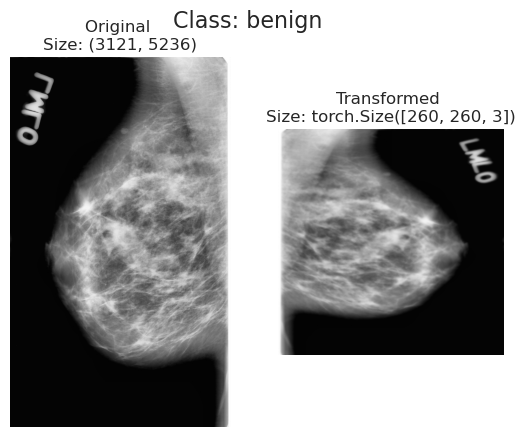

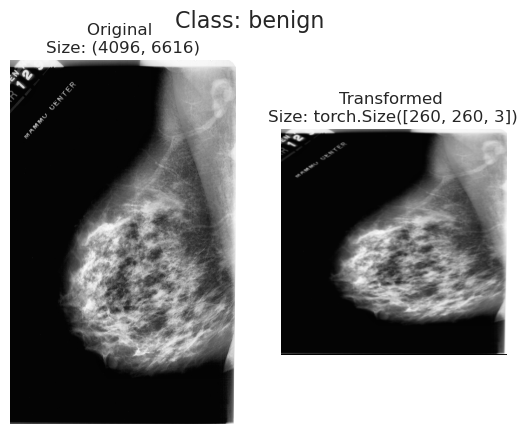

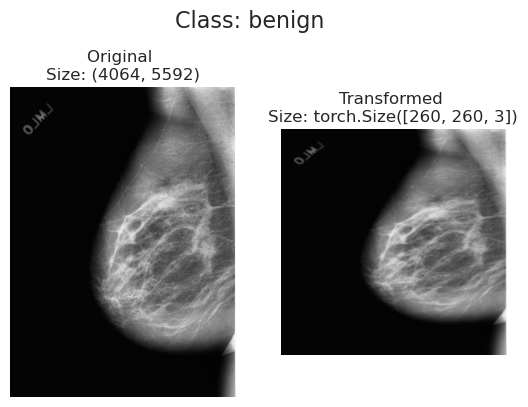

In [16]:
image_path = "/home/hice1/pwang393/scratch/test5"
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")
random_image_path = random.choice(image_path_list)


def plot_transformed_images(image_paths, transform, n=3, seed=40):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=train_transform, n=3)

In [17]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

In [18]:
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS,
                                        pin_memory=True,
                                        persistent_workers=True,
                                        prefetch_factor=2)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE * 2, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS,
                                       pin_memory=True,
                                       persistent_workers=True,
                                       prefetch_factor=2)

## Model

In [22]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
class EfficientNetB1Classifier(nn.Module):
    def __init__(self, num_classes=1):  
        super().__init__()
        # Load EfficientNet-B1 with pretrained weights
        self.efficient = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
        num_features = self.efficient.classifier[1].in_features  
        
        # Classifer
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
        )
        self.efficient.classifier = nn.Identity()
    
    def forward(self, x):
        x = self.efficient(x)
        return self.classifier(x)

class EfficientNetV2Classifier(nn.Module):
    def __init__(self, num_classes=1):  
        super().__init__()
        
        self.efficient = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        
        num_features = 1280
        self.efficient.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256), 
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
      x = self.efficient(x)  
      x = self.classifier(x)  
      return x
    
import timm

class InceptionResNetV2Classifier(nn.Module):
    def __init__(self, num_classes=1):  
        super().__init__()
        
        self.inception_resnet = timm.create_model(
            'inception_resnet_v2', 
            pretrained=True,
            num_classes=0  
        )
        self.inception_resnet.classif = nn.Identity()

        num_features = self.inception_resnet.num_features
        

        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256), 
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        features = self.inception_resnet(x)
        return self.classifier(features)


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB1Classifier(num_classes=1).to(device) # use EfficientNetB1

In [23]:
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) 

Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNetB1Classifier                                     [1, 1]                    --
├─EfficientNet: 1-1                                          [1, 1280]                 --
│    └─Sequential: 2-1                                       [1, 1280, 9, 9]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 32, 130, 130]         928
│    │    └─Sequential: 3-2                                  [1, 16, 130, 130]         2,060
│    │    └─Sequential: 3-3                                  [1, 24, 65, 65]           27,424
│    │    └─Sequential: 3-4                                  [1, 40, 33, 33]           77,930
│    │    └─Sequential: 3-5                                  [1, 80, 17, 17]           345,830
│    │    └─Sequential: 3-6                                  [1, 112, 17, 17]          751,720
│    │    └─Sequential: 3-7                                  [1, 192, 9, 

In [24]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    num_batches = len(dataloader)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.float().view(-1, 1)
        
        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += ((y_pred_class == y).sum().item()/len(y))

    # Calculate averages
    train_loss = train_loss / num_batches
    train_acc = train_acc / num_batches
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    num_batches = len(dataloader)

    true_y = []
    pred_y = []
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y = y.float().view(-1, 1)
    
            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
            test_acc += ((y_pred_class == y).sum().item()/len(y))

            # Store predictions and true labels
            true_y.extend(y.cpu().numpy())
            pred_y.extend(y_pred.cpu().numpy())
            
    # Calculate averages
    test_loss = test_loss / num_batches
    test_acc = test_acc / num_batches
    return test_loss, test_acc, true_y, pred_y

In [27]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          epochs: int = 5):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "true_y": [],         
        "pred_y": [] 
    }

    os.makedirs('model_checkpoints', exist_ok=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc, true_y, pred_y = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'true_y': true_y, 
            '[pred_y]': pred_y
        }
        torch.save(checkpoint, f'model_checkpoints/model_epoch_{epoch+1}.pth')

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_acc)  
            else:
                scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
    
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"Learning Rate: {current_lr:.6f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["true_y"].append(true_y)  
        results["pred_y"].append(pred_y)  

    return results

## Run

In [28]:
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.95, device=torch.cuda.current_device())

In [29]:
torch.manual_seed(41) # Set random seeds
torch.cuda.manual_seed(41)
# Set number of epochs
NUM_EPOCHS = 30
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,     
    weight_decay=0.01,  
    betas=(0.9, 0.98),   
    eps=1e-7
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',         
    factor=0.2,         
    patience=2,         
    min_lr=5e-7         
)

from timeit import default_timer as timer 
start_time = timer()
# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      scheduler=scheduler,
                      epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [00:50<24:26, 50.56s/it]

Epoch: 1 | train_loss: 0.6963 | train_acc: 0.4629 | test_loss: 0.6911 | test_acc: 0.5260 | Learning Rate: 0.000100


  7%|▋         | 2/30 [01:31<20:57, 44.91s/it]

Epoch: 2 | train_loss: 0.6929 | train_acc: 0.5097 | test_loss: 0.6831 | test_acc: 0.6453 | Learning Rate: 0.000100


 10%|█         | 3/30 [02:11<19:15, 42.81s/it]

Epoch: 3 | train_loss: 0.6751 | train_acc: 0.5969 | test_loss: 0.6453 | test_acc: 0.6589 | Learning Rate: 0.000100


 13%|█▎        | 4/30 [02:53<18:17, 42.19s/it]

Epoch: 4 | train_loss: 0.6649 | train_acc: 0.6027 | test_loss: 0.6311 | test_acc: 0.6385 | Learning Rate: 0.000100


 17%|█▋        | 5/30 [03:33<17:23, 41.72s/it]

Epoch: 5 | train_loss: 0.6346 | train_acc: 0.6344 | test_loss: 0.6115 | test_acc: 0.6792 | Learning Rate: 0.000100


 20%|██        | 6/30 [04:14<16:31, 41.33s/it]

Epoch: 6 | train_loss: 0.6154 | train_acc: 0.6681 | test_loss: 0.5917 | test_acc: 0.7302 | Learning Rate: 0.000100


 23%|██▎       | 7/30 [04:55<15:45, 41.11s/it]

Epoch: 7 | train_loss: 0.6058 | train_acc: 0.6805 | test_loss: 0.5775 | test_acc: 0.7255 | Learning Rate: 0.000100


 27%|██▋       | 8/30 [05:36<15:03, 41.07s/it]

Epoch: 8 | train_loss: 0.5748 | train_acc: 0.7158 | test_loss: 0.6057 | test_acc: 0.6964 | Learning Rate: 0.000100


 30%|███       | 9/30 [06:16<14:16, 40.80s/it]

Epoch: 9 | train_loss: 0.5670 | train_acc: 0.7023 | test_loss: 0.5540 | test_acc: 0.7422 | Learning Rate: 0.000100


 33%|███▎      | 10/30 [06:56<13:34, 40.72s/it]

Epoch: 10 | train_loss: 0.5575 | train_acc: 0.7190 | test_loss: 0.5271 | test_acc: 0.7411 | Learning Rate: 0.000100


 37%|███▋      | 11/30 [07:37<12:53, 40.69s/it]

Epoch: 11 | train_loss: 0.5410 | train_acc: 0.7166 | test_loss: 0.5357 | test_acc: 0.7427 | Learning Rate: 0.000100


 40%|████      | 12/30 [08:18<12:15, 40.84s/it]

Epoch: 12 | train_loss: 0.4969 | train_acc: 0.7667 | test_loss: 0.5195 | test_acc: 0.7333 | Learning Rate: 0.000100


 43%|████▎     | 13/30 [08:59<11:31, 40.70s/it]

Epoch: 13 | train_loss: 0.4899 | train_acc: 0.7633 | test_loss: 0.5476 | test_acc: 0.7422 | Learning Rate: 0.000100


 47%|████▋     | 14/30 [09:39<10:50, 40.68s/it]

Epoch: 14 | train_loss: 0.4726 | train_acc: 0.7716 | test_loss: 0.5404 | test_acc: 0.7313 | Learning Rate: 0.000020


 50%|█████     | 15/30 [10:20<10:11, 40.78s/it]

Epoch: 15 | train_loss: 0.4522 | train_acc: 0.7822 | test_loss: 0.5186 | test_acc: 0.7557 | Learning Rate: 0.000020


 53%|█████▎    | 16/30 [11:02<09:34, 41.00s/it]

Epoch: 16 | train_loss: 0.4710 | train_acc: 0.7703 | test_loss: 0.5130 | test_acc: 0.7505 | Learning Rate: 0.000020


 57%|█████▋    | 17/30 [11:42<08:50, 40.83s/it]

Epoch: 17 | train_loss: 0.4569 | train_acc: 0.7875 | test_loss: 0.5342 | test_acc: 0.7448 | Learning Rate: 0.000020


 60%|██████    | 18/30 [12:23<08:08, 40.73s/it]

Epoch: 18 | train_loss: 0.4306 | train_acc: 0.8006 | test_loss: 0.5110 | test_acc: 0.7661 | Learning Rate: 0.000020


 63%|██████▎   | 19/30 [13:03<07:27, 40.71s/it]

Epoch: 19 | train_loss: 0.4442 | train_acc: 0.7854 | test_loss: 0.5194 | test_acc: 0.7531 | Learning Rate: 0.000020


 67%|██████▋   | 20/30 [13:44<06:46, 40.67s/it]

Epoch: 20 | train_loss: 0.4382 | train_acc: 0.7912 | test_loss: 0.5302 | test_acc: 0.7661 | Learning Rate: 0.000020


 70%|███████   | 21/30 [14:25<06:07, 40.82s/it]

Epoch: 21 | train_loss: 0.4248 | train_acc: 0.8120 | test_loss: 0.5468 | test_acc: 0.7661 | Learning Rate: 0.000004


 73%|███████▎  | 22/30 [15:06<05:26, 40.82s/it]

Epoch: 22 | train_loss: 0.4051 | train_acc: 0.8261 | test_loss: 0.5291 | test_acc: 0.7609 | Learning Rate: 0.000004


 77%|███████▋  | 23/30 [15:47<04:46, 40.87s/it]

Epoch: 23 | train_loss: 0.3999 | train_acc: 0.8140 | test_loss: 0.5424 | test_acc: 0.7583 | Learning Rate: 0.000004


 80%|████████  | 24/30 [16:28<04:05, 40.85s/it]

Epoch: 24 | train_loss: 0.4339 | train_acc: 0.8091 | test_loss: 0.5353 | test_acc: 0.7557 | Learning Rate: 0.000001


 83%|████████▎ | 25/30 [17:09<03:24, 40.98s/it]

Epoch: 25 | train_loss: 0.4215 | train_acc: 0.8101 | test_loss: 0.5303 | test_acc: 0.7531 | Learning Rate: 0.000001


 87%|████████▋ | 26/30 [17:50<02:43, 40.91s/it]

Epoch: 26 | train_loss: 0.4126 | train_acc: 0.8164 | test_loss: 0.5287 | test_acc: 0.7505 | Learning Rate: 0.000001


 90%|█████████ | 27/30 [18:31<02:02, 40.96s/it]

Epoch: 27 | train_loss: 0.4253 | train_acc: 0.8043 | test_loss: 0.5297 | test_acc: 0.7609 | Learning Rate: 0.000000


 93%|█████████▎| 28/30 [19:12<01:21, 40.90s/it]

Epoch: 28 | train_loss: 0.4083 | train_acc: 0.8094 | test_loss: 0.5209 | test_acc: 0.7453 | Learning Rate: 0.000000


 97%|█████████▋| 29/30 [19:53<00:40, 40.93s/it]

Epoch: 29 | train_loss: 0.4173 | train_acc: 0.8137 | test_loss: 0.5376 | test_acc: 0.7505 | Learning Rate: 0.000000


100%|██████████| 30/30 [20:33<00:00, 41.13s/it]

Epoch: 30 | train_loss: 0.4180 | train_acc: 0.8096 | test_loss: 0.5208 | test_acc: 0.7505 | Learning Rate: 0.000000
Total training time: 1233.889 seconds


In [33]:
torch.save(model, 'model.pth') # save model to retreive results

torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'true_y': model_results['true_y'][-1],  
    'pred_y': model_results['pred_y'][-1]  
}, 'model_checkpoint.pth')

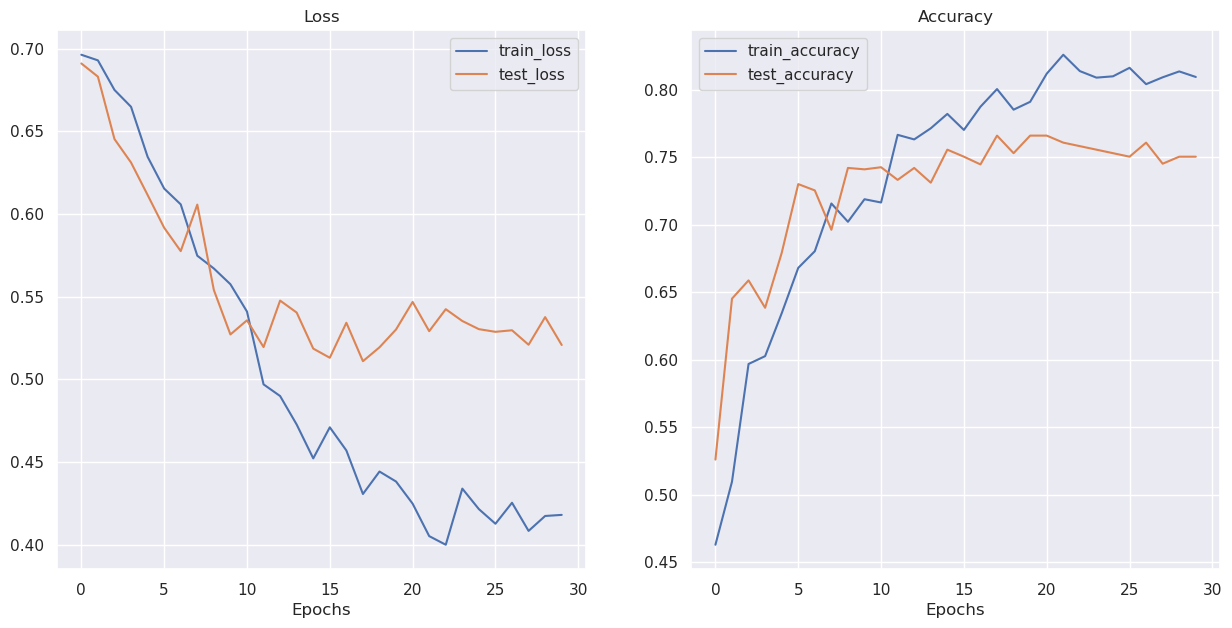

In [34]:
def plot_loss_curves(results):
    results = dict(list(model_results.items())) # get results

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    # loss graph
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

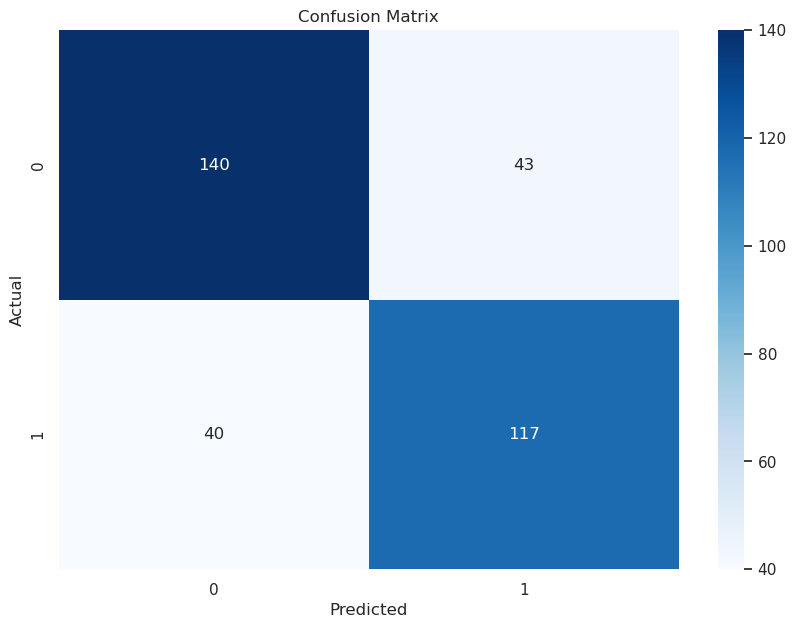

F1 Score for class 0: 0.77
F1 Score for class 1: 0.74
Macro F1 Score: 0.75
Micro F1 Score: 0.76
Weighted F1 Score: 0.76


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

results = dict(list(model_results.items()))

# get result from last epoch
true_y = np.array(results['true_y'][-1])
pred_y = np.array(results['pred_y'][-1])

pred_y_binary = (pred_y > 0.5).astype(int)  # Apply threshold

# confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y_binary)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# f1 score
f1_per_class = f1_score(true_y, pred_y_binary, average=None)  
for i, f1 in enumerate(f1_per_class):
    print(f"F1 Score for class {i}: {f1:.2f}")

f1_macro = f1_score(true_y, pred_y_binary, average='macro')
f1_micro = f1_score(true_y, pred_y_binary, average='micro')
f1_weighted = f1_score(true_y, pred_y_binary, average='weighted')

print(f"Macro F1 Score: {f1_macro:.2f}")
print(f"Micro F1 Score: {f1_micro:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")